#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14B Predicting AirBnB apartment prices: selecting a regression model**

using the airbnb dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import matplotlib as mpl
import patsy
import pandas as pd
import pyfixest as pf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]
# location folders
data_in = dirname + "da_data_repo/airbnb/clean/"
data_out = dirname + "da_case_studies/ch14-airbnb-reg/"
output = dirname + "da_case_studies/ch14-airbnb-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


import da_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

### Part 1

In [3]:
# !!! make sure you have run ch14_airbnb_prepare.ipynb before
data = pd.read_csv(data_out + "airbnb_hackney_workfile_adj.csv")

Quick look at data

In [4]:
data.describe()

,usd_cleaning_fee,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
count,2769.000000,4496.000000,2970.000000,4496.000000,4487.000000,3073.000000,4496.000000,4496.000000,3147.000000,4496.000000,...,4487.000000,4496.000000,4495.000000,3146.000000,3146.000000,3146.000000,3.147000e+03,3.147000e+03,3073.000000,4495.000000
mean,31.439870,80.556940,90.924579,2.864324,1.225986,93.323788,10.141904,1.385454,0.946295,5.991770,...,1.150435,1.414416,0.745050,5.813246,34.920619,214.912424,4.386975e+05,5.008933e+08,4.529253,2.029366
std,25.871418,58.915794,21.642376,1.722148,0.480064,9.133501,22.342473,0.996658,1.143208,11.255617,...,0.379318,1.318117,0.529467,1.061670,11.357470,96.884368,6.959114e+05,1.179754e+09,0.130507,0.838032
min,4.000000,10.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,15.000000,40.000000,96.000000,2.000000,1.000000,90.000000,0.000000,1.000000,0.210000,0.000000,...,1.000000,0.000000,0.000000,5.269144,27.763878,146.291911,3.763600e+04,7.301384e+06,4.499810,1.000000
50%,25.000000,65.000000,100.000000,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,...,1.000000,1.098612,1.000000,6.006350,36.076248,216.686649,1.640250e+05,6.643012e+07,4.564348,2.000000
75%,40.000000,100.000000,100.000000,4.000000,1.500000,100.000000,10.000000,1.000000,1.190000,10.000000,...,1.000000,2.397895,1.000000,6.512487,42.412491,276.210824,4.529300e+05,3.048232e+08,4.605170,3.000000
max,500.000000,850.000000,100.000000,16.000000,8.000000,100.000000,290.000000,12.000000,9.729999,200.000000,...,2.000000,5.673323,2.000000,7.773594,60.428771,469.748759,5.650129e+06,1.343036e+10,4.605170,3.000000


where do we have missing variables now?

In [5]:
data.isnull().sum().loc[lambda x: x > 0]

usd_cleaning_fee           1727
p_host_response_rate       1526
n_bathrooms                   9
n_review_scores_rating     1423
n_reviews_per_month        1349
n_beds                       12
n_days_since               1349
ln_beds                      12
f_bathroom                    9
f_number_of_reviews           1
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
f_minimum_nights              1
dtype: int64

What to do with missing values?

   1. drop if no target (already did)

In [6]:
data = data.dropna(subset=["price"])

 2. imput when few, not that important

In [7]:
data["n_bathrooms"] = data["n_bathrooms"].fillna(np.nanmedian(data["n_bathrooms"]))
data["n_beds"] = data["n_beds"].fillna(data["n_accommodates"])
data["f_bathroom"] = data["f_bathroom"].fillna(1)
data["f_minimum_nights"] = data["f_minimum_nights"].fillna(1)
data["f_number_of_reviews"] = data["f_number_of_reviews"].fillna(1)
data["ln_beds"] = data["ln_beds"].fillna(0)

In [8]:
data["n_bathrooms"].describe()

count    4496.000000
mean        1.225534
std         0.479690
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max         8.000000
Name: n_bathrooms, dtype: float64

 3. drop columns when many missing not imortant

In [9]:
data = data.drop(["usd_cleaning_fee", "p_host_response_rate"], axis=1)

 where do we have missing variables now?

In [10]:
data.isnull().sum().loc[lambda x: x > 0]

n_review_scores_rating     1423
n_reviews_per_month        1349
n_days_since               1349
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
dtype: int64

 4. Replace missing variables re reviews with zero, when no review + add flags

In [11]:
for var in ["flag_days_since", "flag_review_scores_rating", "flag_reviews_per_month"]:
    data[var] = [int(x) for x in data[var.replace("flag", "n")].isna()]

In [12]:
data["n_days_since"] = data["n_days_since"].fillna(np.nanmedian(data["n_days_since"]))
data["n_review_scores_rating"] = data["n_review_scores_rating"].fillna(
    np.nanmedian(data["n_review_scores_rating"])
)
data["n_reviews_per_month"] = data["n_reviews_per_month"].fillna(
    np.nanmedian(data["n_reviews_per_month"])
)

In [13]:
data.flag_days_since.value_counts()

flag_days_since
0    3147
1    1349
Name: count, dtype: int64

Add features -> different functional forms

Create variables, measuring the time since: squared, cubic, logs


In [14]:
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
).assign(
    ln_days_since=lambda x: np.where(
        x["ln_days_since"].isnull(), 0, x["ln_days_since"]
    ),
    ln_days_since2=lambda x: np.where(
        x["ln_days_since2"].isnull(), 0, x["ln_days_since2"]
    ),
    ln_days_since3=lambda x: np.where(
        x["ln_days_since3"].isnull(), 0, x["ln_days_since3"]
    ),
)

Look at data

In [15]:
data.describe()

,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights,flag_days_since,flag_review_scores_rating,flag_reviews_per_month
count,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,...,4496.000000,4496.000000,4496.000000,4.496000e+03,4.496000e+03,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000
mean,80.556940,2.864324,1.225534,94.170819,10.141904,1.385454,0.818387,5.991770,3.127002,1.577847,...,5.874549,35.296294,215.650102,3.562836e+05,3.705350e+08,4.540361,2.029137,0.300044,0.316504,0.300044
std,58.915794,1.722148,0.479690,7.652561,22.342473,0.996658,0.976154,11.255617,6.160668,1.044372,...,0.886647,9.482548,80.906146,5.956503e+05,1.006861e+09,0.109118,0.838079,0.458328,0.465164,0.458328
min,10.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000,0.000000,0.000000,0.000000
25%,40.000000,2.000000,1.000000,93.000000,0.000000,1.000000,0.330000,0.000000,1.000000,1.000000,...,5.551989,30.824581,171.137760,6.592075e+04,1.692525e+07,4.532599,1.000000,0.000000,0.000000,0.000000
50%,65.000000,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,2.000000,1.000000,...,6.006353,36.076278,216.686868,1.640250e+05,6.643012e+07,4.564348,2.000000,0.000000,0.000000,0.000000
75%,100.000000,4.000000,1.500000,98.000000,10.000000,1.000000,0.860000,10.000000,3.000000,2.000000,...,6.335054,40.132912,254.244177,3.169690e+05,1.784535e+08,4.584967,3.000000,1.000000,1.000000,1.000000
max,850.000000,16.000000,8.000000,100.000000,290.000000,12.000000,9.729999,200.000000,180.000000,16.000000,...,7.774015,60.435310,469.825014,5.650129e+06,1.343036e+10,4.605170,3.000000,1.000000,1.000000,1.000000


 where do we have missing variables now?

In [16]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

### Business logic - define our prediction problem

Decision

Size, we need a normal apartment, 1-7persons

In [17]:
data = data.loc[data.n_accommodates < 8]

In [18]:
data.to_csv("airbnb_hackney_work.csv", index=False)

### Look at some descriptive statistics

How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?

In [19]:
data.groupby(["f_property_type", "f_room_type"]).agg(mean_price=("price", np.mean))

mean_price
f_property_type f_room_type                
Apartment       Entire home/apt  106.364341
                Private room      48.034439
                Shared room       50.708333
House           Entire home/apt  134.794118
                Private room      42.931487
                Shared room       38.666667

In [20]:
data.groupby(["f_bed_type"]).agg(mean_price=("price", np.mean))

,mean_price
f_bed_type,
Couch,49.091954
Real Bed,77.838365


In [21]:
data.price.describe()

count    4393.000000
mean       77.269064
std        53.265471
min        10.000000
25%        40.000000
50%        65.000000
75%        99.000000
max       850.000000
Name: price, dtype: float64

 NB all graphs, we exclude  extreme values of price

In [22]:
datau = data.loc[data.price < 400]

Histograms price

Distribution of price by type below 400

### Figure 14.3 Airbnb apartment price and ln price distributions.

(a) Price

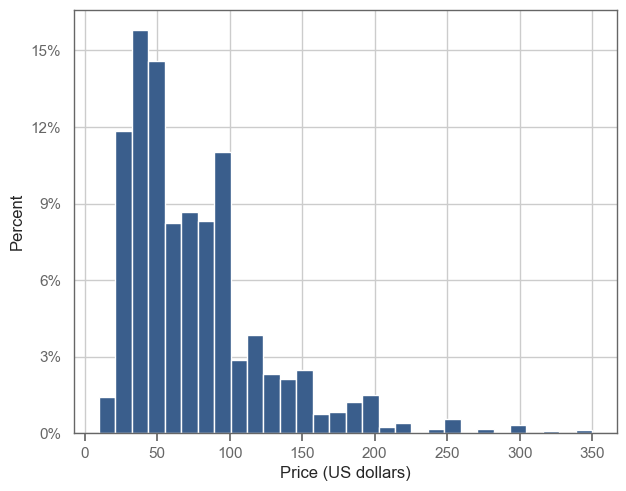

In [23]:
sns.histplot(datau, x="price", bins=30, alpha=1, stat="probability")
plt.ylabel("Percent")
plt.xlabel("Price (US dollars)")
plt.yticks(
    np.arange(0, 0.16, 0.03),
    labels=[f"{100 * y:.0f}%" for y in np.arange(0, 0.16, 0.03)],
)
plt.show()

(b) Price in log

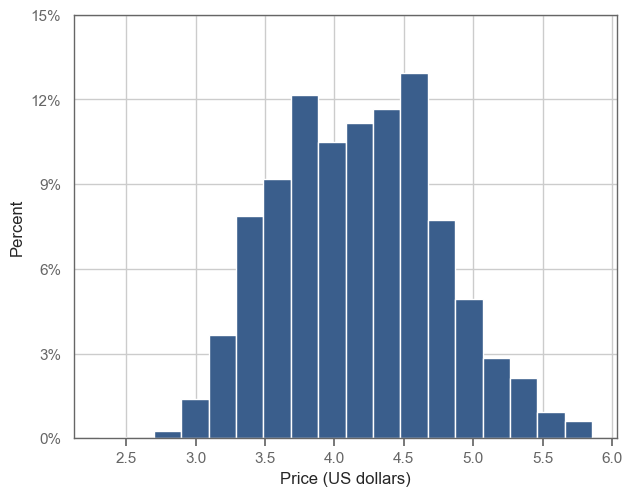

In [24]:
sns.histplot(datau, x="ln_price", bins=30, alpha=1, stat="probability", binwidth=0.2)
plt.ylabel("Percent")
plt.xlabel("Price (US dollars)")
plt.yticks(
    np.arange(0, 0.16, 0.03),
    labels=[f"{100 * y:.0f}%" for y in np.arange(0, 0.16, 0.03)],
)
plt.show()

### Figure 14.4 Airbnb apartment price distribution by important features

(a) Price by room type

In [25]:
datau["f_room_type"] = pd.Categorical(
    datau["f_room_type"], categories=sorted(set(datau["f_room_type"]), reverse=False)
)

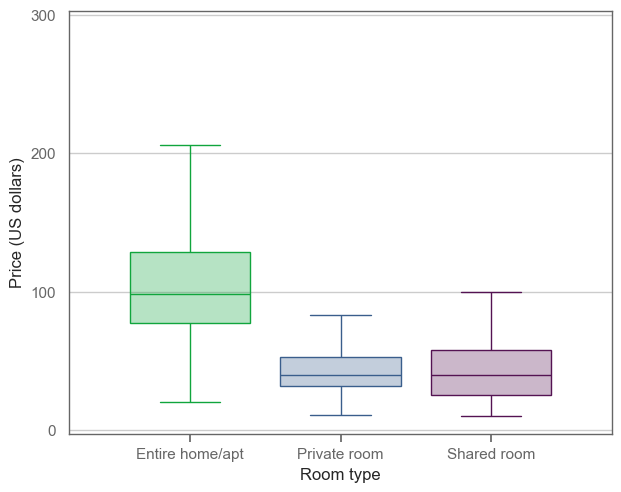

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=datau, x="f_room_type", y="price", width=0.8, ax=ax, showfliers=False)

box_line_col = [da.color[1], da.color[0], da.color[2]]
for i, box_col in enumerate(box_line_col):
    mybox = ax.patches[i]
    mybox.set_facecolor(mpl.colors.to_rgba(box_col, 0.3))
    mybox.set_edgecolor(box_col)
    for j in range(i * 5, i * 5 + 5):
        line = ax.lines[j]
        line.set_color(box_col)

plt.ylabel("Price (US dollars)", size=12)
plt.xlabel("Room type", size=12)
plt.yticks(da.seq(0, 300, 100))
da.add_margin(ax, x=0.1, y=0.01)
plt.show()

(b) Price by number of people accommodated and apartment versus house in US dollars

In [27]:
datau["n_accommodates"] = datau["n_accommodates"].astype(int).astype("category")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


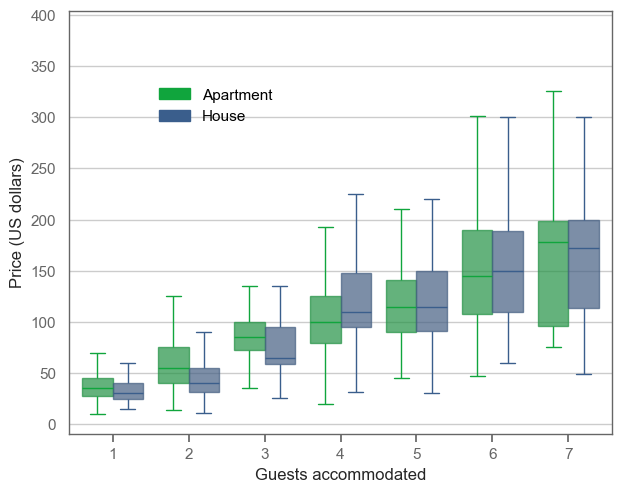

In [28]:
fig, ax = plt.subplots()
# Create the boxplot
sns.boxplot(
    x="n_accommodates",
    y="price",
    hue="f_property_type",
    data=datau,
    showfliers=False,
    palette={"Apartment": da.color[1], "House": da.color[0]},
)


for patch in ax.patches:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
    patch.set_edgecolor((r, g, b, 0.7))


for i in range(0, int(len(ax.lines) / 2)):
    ax.lines[i].set_color(da.color[1])

for i in range(int(len(ax.lines) / 2), len(ax.lines)):
    ax.lines[i].set_color(da.color[0])

ax.legend(bbox_to_anchor=(0.4, 0.85), framealpha=0)
leg = ax.get_legend()
leg.set_title(None)
leg.legend_handles[0].set_color(da.color[1])
leg.legend_handles[1].set_color(da.color[0])

plt.ylabel("Price (US dollars)", size=12)
plt.xlabel("Guests accommodated", size=12)
plt.yticks(da.seq(0, 400, 50))
da.add_margin(ax, x=0.01, y=0.01)
plt.show()

### Part2

In [29]:
data = pd.read_csv("airbnb_hackney_work.csv")

### Setting up models

Basic variables

In [30]:
basic_lev = (
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_days_since",
    "flag_days_since",
)
basic_add = ("f_bathroom", "f_cancellation_policy", "f_bed_type")
reviews = ("f_number_of_reviews", "n_review_scores_rating", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")
# not use p_host_response_rate due to missing obs
amenities = tuple(list(data.filter(regex="^d_.*")))

### Look for interactions

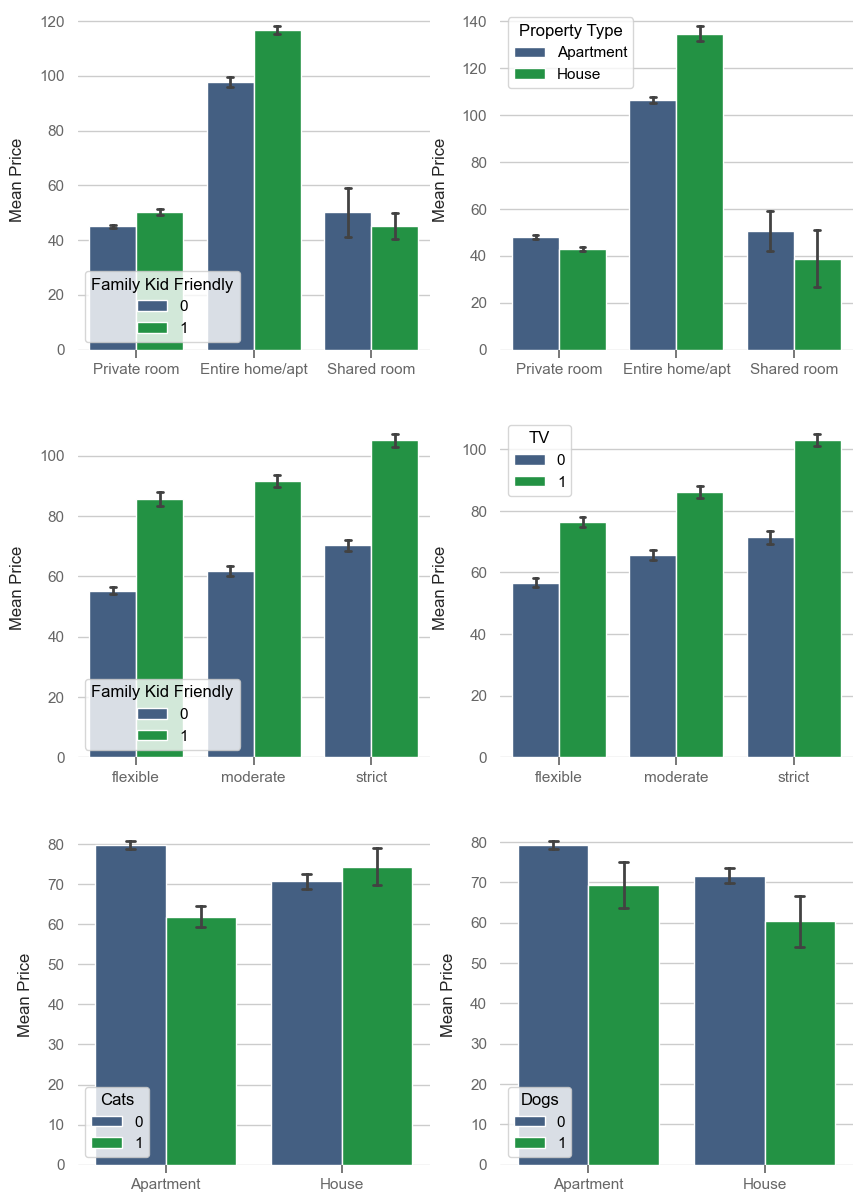

In [31]:
plot_config = [
    {
        "x": "f_room_type",
        "y": "price",
        "hue": "d_familykidfriendly",
        "legend_title": "Family Kid Friendly",
    },
    {
        "x": "f_room_type",
        "y": "price",
        "hue": "f_property_type",
        "legend_title": "Property Type",
    },
    {
        "x": "f_cancellation_policy",
        "y": "price",
        "hue": "d_familykidfriendly",
        "legend_title": "Family Kid Friendly",
    },
    {"x": "f_cancellation_policy", "y": "price", "hue": "d_tv", "legend_title": "TV"},
    {"x": "f_property_type", "y": "price", "hue": "d_cats", "legend_title": "Cats"},
    {"x": "f_property_type", "y": "price", "hue": "d_dogs", "legend_title": "Dogs"},
]

da.plot_interactions(data, plot_config)

Dummies suggested by graphs

In [32]:
X1 = ("f_room_type*f_property_type", "f_room_type*d_familykidfriendly")

 Additional interactions of factors and dummies

In [33]:
X2 = (
    "d_airconditioning*f_property_type",
    "d_cats*f_property_type",
    "d_dogs*f_property_type",
)
X3 = (
    "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * ("
    + "+".join(amenities)
    + ")"
)

Create estimation equations

In [34]:
modellev1 = "~ n_accommodates"
modellev2 = "~" + " + ".join(basic_lev)
modellev3 = "~" + " + ".join(basic_lev + basic_add + reviews)
modellev4 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev)
modellev5 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev + X1)
modellev6 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev + X1 + X2)
modellev7 = "~" + " + ".join(
    basic_lev + basic_add + reviews + poly_lev + X1 + X2 + amenities
)
modellev8 = (
    "~"
    + "+".join(basic_lev + basic_add + reviews + poly_lev + X1 + X2 + amenities)
    + "+"
    + X3
)

model_equations = [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]

### Create separate holdout set

In [35]:
sample_size = round(0.2 * data.shape[0]) - 1

 Set the random number generator: It will make results reproducable

In [36]:
np.random.seed(20180123)

In [37]:
from sklearn.model_selection import train_test_split

data_work, data_holdout = train_test_split(data, test_size=sample_size)

### Crossvalidation

Use custom function `ols_crossvalidator` for cross validation

In [38]:
# help(da.ols_crossvalidator)

Set number of folds

In [39]:
n_folds = 5

Cross validate for each model and save results in `cv_list`

In [40]:
cv_list = []
for model in model_equations:
    cv_list += [da.ols_crossvalidator("price" + model, data_work, n_folds)]

### Table 14.3 Comparing model fit measures

In [41]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,2,0.40,36132,41.18,40.96
1,M2,8,0.48,35703,38.46,38.23
2,M3,15,0.51,35563,37.38,37.26
3,M4,18,0.51,35551,37.18,37.15
4,M5,23,0.52,35575,37.09,37.07
5,M6,29,0.52,35607,36.99,37.03
6,M7,74,0.54,35775,35.92,36.49
7,M8,310,0.57,37458,34.45,38.71


### Figure 14.7 Training and test set RMSE for the eight regression models

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


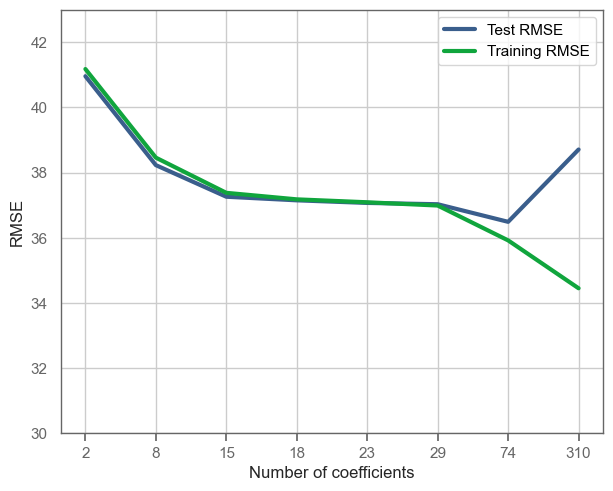

In [42]:
df_melted = compare_model_fits.melt(
    id_vars="Coefficients", value_vars=["Test RMSE", "Training RMSE"]
).assign(Coefficients=lambda x: x["Coefficients"].astype(str))

sns.lineplot(data=df_melted, x="Coefficients", y="value", hue="variable", linewidth=3)
plt.xlabel("Number of coefficients")
plt.ylabel("RMSE")
plt.ylim(30, 43)
plt.yticks(np.arange(30, 44, 2))
plt.legend(title="")
plt.show()

**NOTE:** Because the way we created the work and holdout sets relies on randomization, these results (eg. the number of coefficients) differ from R and book results. Even running the cross validation with exactly the same work set would result in slightly different RMSE results because we cannot control for the randomisation within the cross validation. Using exactly the same work set as R, the number of coefficients match though.

### Lasso

In [43]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

Define Lasso equation from most complicated model

In [44]:
vars_model_8 = modellev8

Define range for lambdas – the algo will look only in this set

In [45]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


To cross-validate lambda-s (which is Lasso's hyperparameter) one has to standardise the feature matrix.

In [46]:
y, X = patsy.dmatrices("price" + vars_model_8, data_work)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [47]:
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

Best alpha the algorithm found

In [48]:
lasso_fit.alpha_

0.35000000000000003

In [49]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)
rmse_lambda_folds

,Test RMSE
1.00,36.52
0.95,36.49
0.90,36.47
0.85,36.45
0.80,36.43
0.75,36.41
0.70,36.39
0.65,36.38
0.60,36.37
0.55,36.37


Non-zero coefficients

In [50]:
notnull_lasso_coefs = (
    pd.DataFrame(lasso_fit.coef_, index=X_featnames, columns=["coefficient"])
    .loc[lambda x: x["coefficient"].round(3) != 0]
    .round(3)
)
notnull_lasso_coefs

,coefficient
f_room_type[T.Private room],-13.159
f_room_type[T.Shared room],-2.401
f_bed_type[T.Real Bed],0.355
f_room_type[T.Private room]:f_property_type[T.House],-2.373
n_days_since,0.786
...,...
f_room_type[T.Shared room]:d_washer,-0.017
d_washerdryer,2.944
f_cancellation_policy[T.moderate]:d_wheelchairaccessible,-0.053
f_cancellation_policy[T.strict]:d_wheelchairaccessible,0.734


In [51]:
compare_model_fits.loc[8, :] = {
    "Model": "Lasso",
    "Coefficients": notnull_lasso_coefs.shape[0],
    "Test RMSE": rmse_lambda_folds.loc[lasso_fit.alpha_].round(2).values[0],
}

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,2.0,0.40,36132.0,41.18,40.96
1,M2,8.0,0.48,35703.0,38.46,38.23
2,M3,15.0,0.51,35563.0,37.38,37.26
3,M4,18.0,0.51,35551.0,37.18,37.15
4,M5,23.0,0.52,35575.0,37.09,37.07
5,M6,29.0,0.52,35607.0,36.99,37.03
6,M7,74.0,0.54,35775.0,35.92,36.49
7,M8,310.0,0.57,37458.0,34.45,38.71
8,Lasso,107.0,NaN,NaN,NaN,36.33


The overall RMSE across the five test sets for the LASSO regression is 36.3. It is 36.49 for M7,
suggesting that our hand-picked M7 is almost as good as the LASSO regression. Our decision is to have the model M7 as our preferred
model, because it may be easier to explain which variables are included.

### Part3

#### Model diagnostics

In [52]:
model7 = pf.feols("price" + modellev7, data=data_work)

Save the predicted values of model 7 ton data_holdout

In [53]:
data_holdout["predicted_price"] = model7.predict(data_holdout)

Look at holdout RMSE of M7

In [54]:
da.rmse(data_holdout["predicted_price"], data_holdout["price"])

37.36313555328213

work set RMSE refitted on the whole work set

In [55]:
da.rmse(model7.predict(data_work), data_work["price"])

36.02053192939146

### Fitted vs actual outcome

### Figure 14.8 Airbnb prediction – model diagnostics

(a) Predicted price vs. actual price

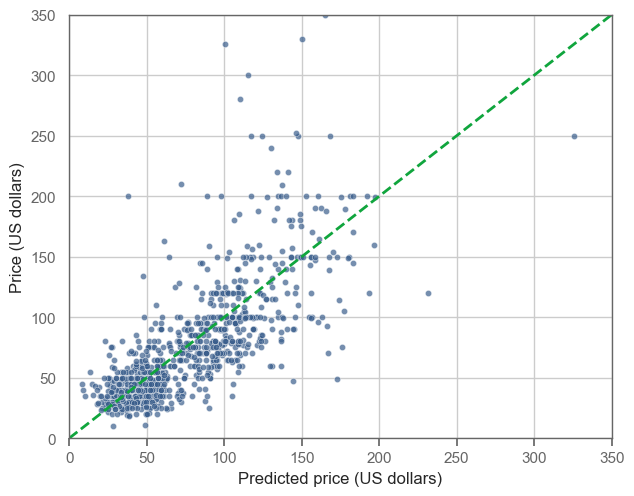

In [56]:
sns.scatterplot(data=data_holdout, x="predicted_price", y="price", s=20, alpha=0.7)
plt.plot([0, 350], [0, 350], linestyle="dashed", linewidth=2, color=da.color[1])
plt.xlim(0, 350)
plt.ylim(0, 350)
plt.xticks(np.arange(0, 351, 50))
plt.yticks(np.arange(0, 351, 50))
plt.xlabel("Predicted price (US dollars)")
plt.ylabel("Price (US dollars)")
plt.show()

Redo predicted values at 80% PI


In [57]:
prediction_agg_by_nacc = (
    model7.predict(data_holdout, interval="prediction", alpha=0.2)
    .rename(columns={"fit": "predicted_price"})
    .assign(n_accommodates=data_holdout["n_accommodates"].values)
    .groupby(by=["n_accommodates"])
    .mean()
    .reset_index()
)

(b) Prediction interval by apartment size

<BarContainer object of 7 artists>

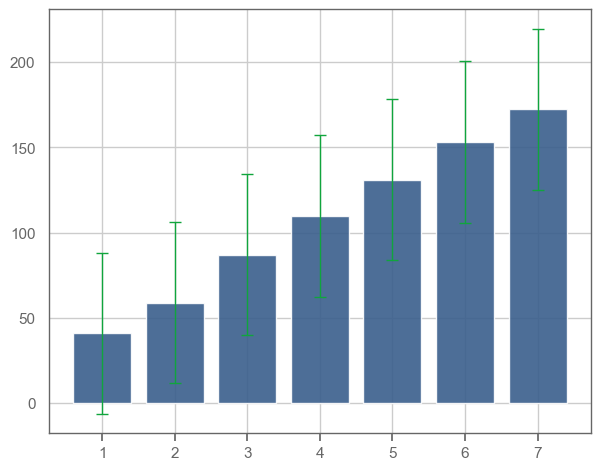

In [58]:
yci_low = prediction_agg_by_nacc["predicted_price"] - prediction_agg_by_nacc["ci_low"]
yci_upper = (
    prediction_agg_by_nacc["ci_high"] - prediction_agg_by_nacc["predicted_price"]
)

plt.bar(
    prediction_agg_by_nacc["n_accommodates"],
    prediction_agg_by_nacc["predicted_price"],
    yerr=[yci_low, yci_upper],
    capsize=4,
    color=da.color[0],
    alpha=0.9,
    error_kw={"elinewidth": 1, "ecolor": da.color[1]},
)

Density chart (not in book)

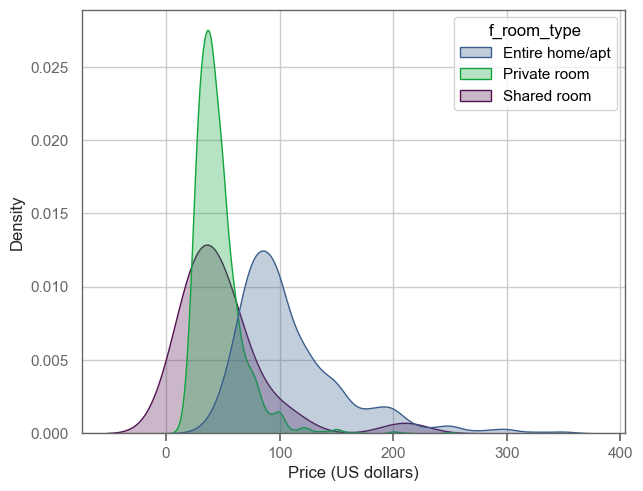

In [59]:
sns.kdeplot(
    data=datau, x="price", hue="f_room_type", fill=True, alpha=0.3, common_norm=False
)
plt.xlabel("Price (US dollars)")
plt.ylabel("Density")
plt.show()

Barchart  (not in book)

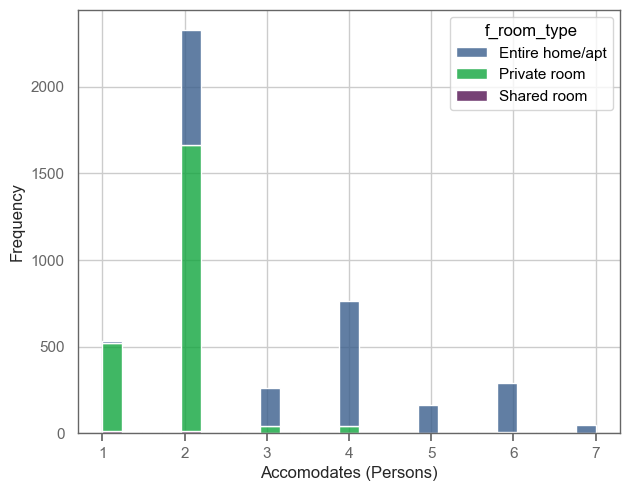

In [60]:
datau["n_accommodates"] = datau["n_accommodates"].astype(int)


sns.histplot(
    x="n_accommodates", hue="f_room_type", data=datau, alpha=0.8, multiple="stack"
)

plt.xlabel("Accomodates (Persons)")
plt.ylabel("Frequency")
plt.show()